# pyMCとpystanの基本
ベイズ推論では事後分布のサンプリングのためにマルコフ連鎖モンテカルロ(MCMC)サンプリングを利用する。pyMCとpystanはベイズ推論のためのMCMCを提供するライブラリである。Rとstanを利用したベイズモデリングに関する本やドキュメントは大量にあるが、pyMCとpystanについてのドキュメントは少ない。pythonのためのPPL(Probabilistic Programming Library)は他にもnumpyroやtensorflow probabilityがあるが、これらの比較は[ここ](https://zenn.dev/yoshida0312/articles/3323b08e1e6e41)が詳しい。

## pyMC
pyMCはpythonのみベイズモデリングを行えるライブラリである。コンテキスト内でモデルの定義、サンプリングを行い、サンプルの扱いや可視化はarvizやmatplotlibに任せている。

pyMCはpythonのみで簡潔に書けるため学習コストは低いが、ドキュメントがまだ少なく(特に日本語)、自由度の高いモデリングはstanに一歩及ばない。

## pystan
pystanでは、pythonでstanを利用するAPIを提供してくれる。stanについてのドキュメントは大量にあり、非常に自由なモデリングが可能である。しかし、stanの学習コストやpymcで提供されている機能をわざわざ実装し直す必要があるなど少し面倒くさいところもある。

## pyMC5の基本
ここでは、pyMC5の基本的な使い方を説明する。
pyMCは、ベイズ推論において重要なツールである「マルコフ連鎖モンテカルロ」サンプリングを提供してくれるライブラリです。特に、ハミルトニアンモンテカルロ(HMC)の次世代型であるNo-U-Turn Sampler (NUTS)アルゴリズムを提供する。

ここでは、正規分布に従うサンプルを次のように正規分布でモデル化するという単純なモデルによってpyMCの使い方を説明する。
$$
Y_n \sim normal(\mu, \sigma^2)
$$


In [1]:
import arviz as az
import pandas as pd
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
import numpy as np

In [2]:
rng = np.random.default_rng(123)
Y = rng.normal(100, 1, 100)

### 共役性を持った正規モデル

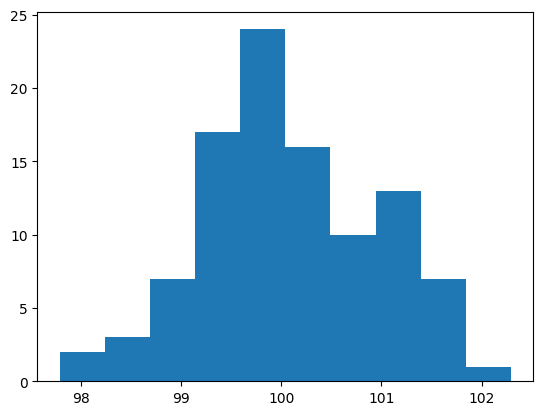

In [3]:
plt.hist(Y)
plt.show()

上のヒストグラムは平均100, 標準偏差1の正規分布に従う100個のサンプルである

「標準ベイズ」を見ればわかるように、$\mu$の事前分布として正規分布を、$\sigma^2$の事前分布として逆ガンマ分布を用いれば、モデルは次のようになる。
$$
1/\sigma^2 \sim gamma(\nu_0/2, \nu_0\sigma_0^2/2)\\
\theta|\sigma^2 \sim normal(\mu_0, \sigma^2/\kappa_0)\\
Y_1, ... ,Y_n|\theta, \sigma^2 \sim i.i.d. normal(\theta, \sigma^2)
$$
パラメータ$\mu, \sigma^2$の事後分布は、正規分布と逆ガンマ分布の共役性から解析的に得られ、次のようになる。
$$
{\theta|y_1,...,y_n, \sigma^2} \sim normal(\mu_n, \sigma^2/\kappa_n)\\
\kappa_n = \kappa_0+n\\
\mu_n = \frac{(\kappa_0/\sigma^2)\mu_0+(n/\sigma^2)\overline{y}}{\kappa_0/\sigma^2+n/\sigma^2}=\frac{\kappa_0\mu_0+n\overline{y}}{\kappa_n}
$$
$$
{1/\sigma^2|y_1,...,y_n} \sim gamma(\nu_n/2, \nu_n\sigma_n^2/2)\\
\nu_n = \nu_0+n\\
\sigma_n^2 = \frac{1}{\nu_n}[\nu_0\sigma_0+(n-1)s^2+\frac{\kappa_0n}{\kappa_n}(\overline{y}-\mu_0)^2]\\
$$

これに従って$\theta, \sigma^2$の事後分布を解析的に求めてみる。平均は100, 標準偏差は1なので、事前分布のハイパーパラメータは次のようにする。(この方法はデータからハイパーパラメータを決定するデータの二度漬けになるので、本来はやってはいけない。経験ベイズと呼ばれる手法はこのデータの二度漬けをしている。)

$$
\nu_0 = 1\\
\kappa_0 = 1\\
\mu_0 = 100\\
\sigma_0^2 = 1
$$

計算すると次のようになる

In [4]:
nu_0 = 1
kappa_0 = 1
mu_0 = 100
sigma_0 = 1
n = len(Y)
x_bar = Y.mean()
s = Y.var()

kappa_n = kappa_0 + n
mu_n = (kappa_0*mu_0 + n*x_bar)/kappa_n

nu_n = nu_0 + n
sigma_n = (1/nu_n)*(nu_0*sigma_0 + (n-1)*s + (kappa_0*n*(x_bar - mu_0)**2)/(kappa_n))
print("mu_n: ", mu_n)
print("sigma_n: ", sigma_n)
print("simga_n_sqrt: ", np.sqrt(sigma_n))

mu_n:  100.0811038218455
sigma_n:  0.7951326039893244
simga_n_sqrt:  0.8917020825305526


よって$\theta, \sigma$の事後分布からのサンプルはモンテカルロサンプリングによって次のように得られる

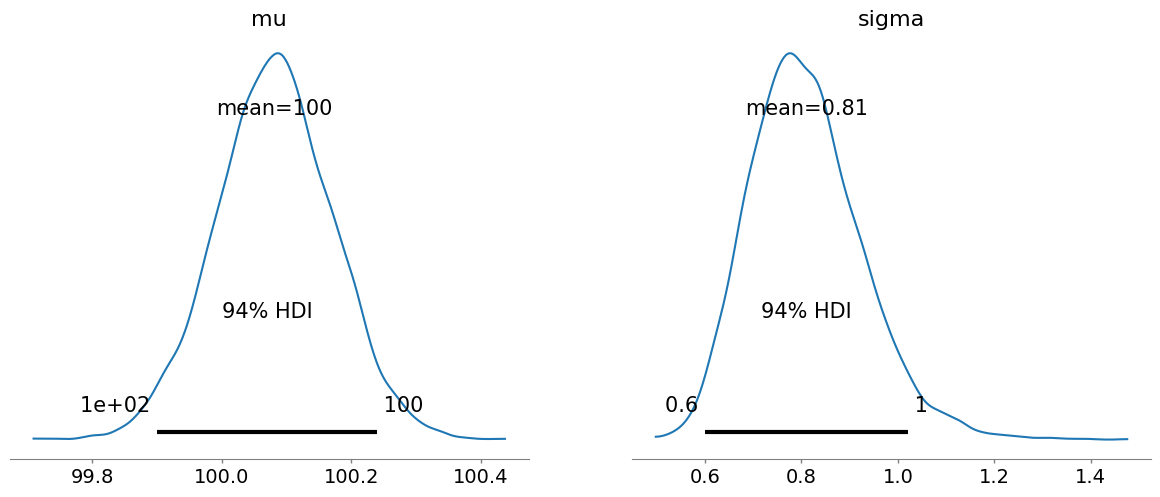

In [5]:
rng = np.random.default_rng(123)
sigma_samples = 1/rng.gamma(nu_n/2, 1/(nu_n*sigma_n/2), 10000)
theta_samples = rng.normal(mu_n, np.sqrt(sigma_samples/kappa_n), 10000)
y_samples = rng.normal(theta_samples, np.sqrt(sigma_samples), 10000)
axes = az.plot_posterior({'mu': theta_samples, 'sigma': sigma_samples})

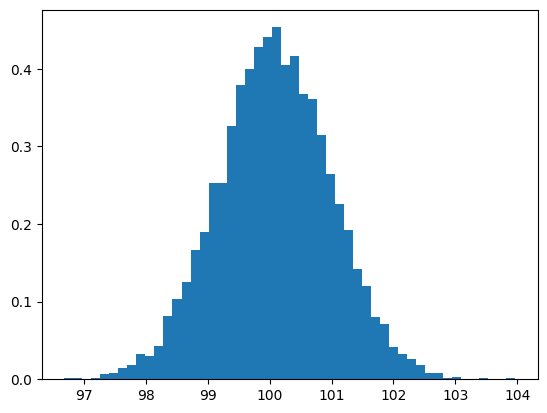

In [6]:
plt.hist(y_samples, bins=50, density=True)
plt.show()

In [7]:
y_samples.mean()

100.07964555533216

In [8]:
y_samples.var()

0.8313124331160717

### MCMCによるサンプリング
これをpyMCによってMCMCを使うことで求める

In [9]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


モデルの定義はコンテキスト内で行う

In [10]:
nu_0 = 1
kappa_0 = 1
mu_0 = 100
sigma_0 = 1
n = len(Y)
x_bar = Y.mean()
s = Y.var()

with pm.Model() as model:
    # mu, sigmaの事前分布は正規分布と逆ガンマ分布
    sigma = pm.InverseGamma("sigma", nu_0/2, 1/(nu_0*sigma_0/2))
    mu = pm.Normal("mu", mu_0, tau=sigma*kappa_0)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=np.sqrt(sigma), observed=Y) 

定義されたグラフィカルモデルは次のようになる

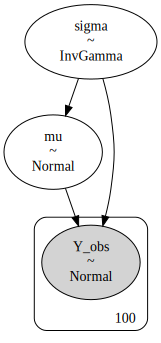

In [11]:
g = pm.model_to_graphviz(model)
display(g)

MCMCの実行はmodelコンテキスト内で行う

drawsは1回のMCMCの系列で取得するサンプル数である。chainsは幾つのMCMC系列を取得するかを決める。tuneはburn in期間で、収束が確認できない最初のステップにおいて、捨てるステップ数を指定する。

In [12]:
with model:
    idata = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=10000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 3 chains for 2_000 tune and 10_000 draw iterations (6_000 + 30_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


MCMCによって得られたパラメータのサンプルの可視化は次のように行う

ここで、サンプルの収束を確認する(今回はちゃんと収束している)

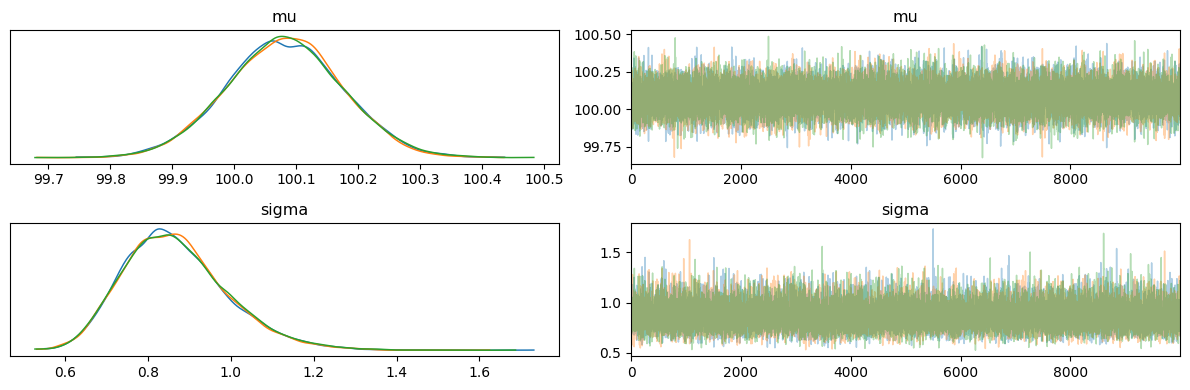

In [13]:
axes = az.plot_trace(idata, compact=False)
plt.tight_layout()

事後分布の確認は次のようにする

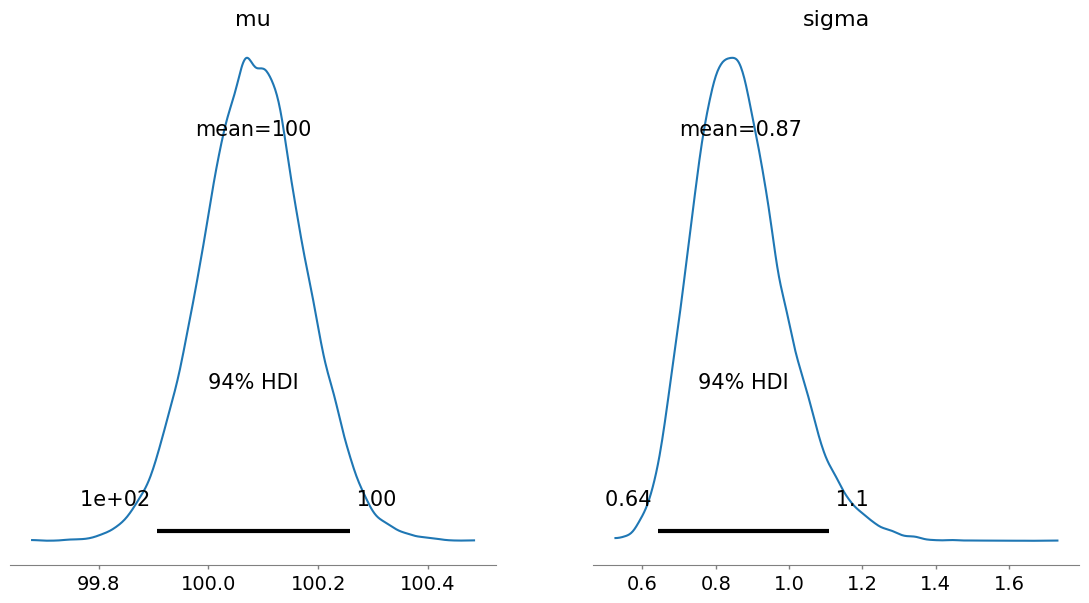

In [14]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(idata)

定量的なサマリーは次のように確認する。ここでr_hatはGelman-Rubin統計量といい収束を評価する値で、1.1以下のとき収束しているとみなして良い

In [15]:
summary = az.summary(idata)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,100.081,0.094,99.906,100.257,0.001,0.000,30654.0,20962.0,1.0
sigma,0.867,0.126,0.644,1.108,0.001,0.001,28424.0,20662.0,1.0


解析的に解いた事後分布と比べると次のようになる

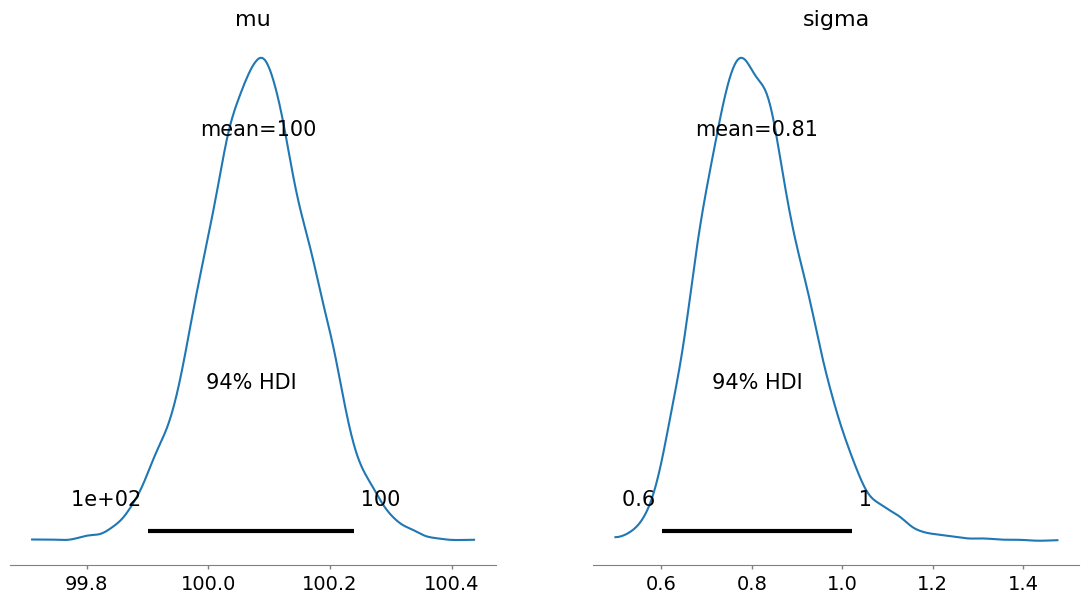

In [16]:
# 解析的な事後分布のサンプリング
rng = np.random.default_rng(123)
sigma_samples = 1/rng.gamma(nu_n/2, 1/(nu_n*sigma_n/2), 10000)
theta_samples = rng.normal(mu_n, np.sqrt(sigma_samples/kappa_n), 10000)
y_samples = rng.normal(theta_samples, np.sqrt(sigma_samples), 10000)
axes = az.plot_posterior({'mu': theta_samples, 'sigma': sigma_samples})

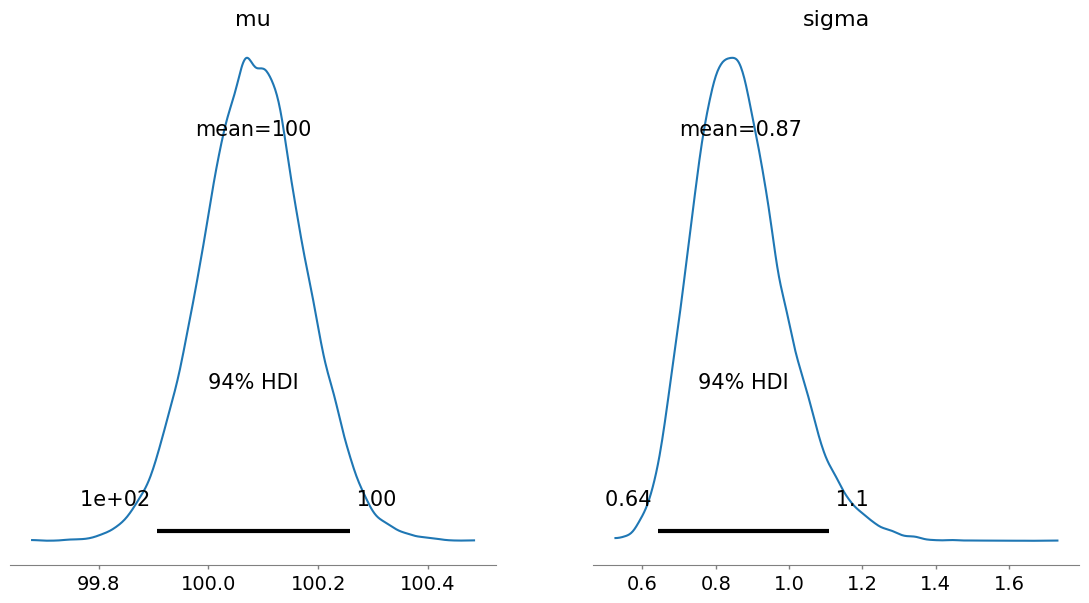

In [17]:
# MCMCでの事後分布のサンプリング
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(idata)

結果がほとんど同じであることが確認できる

### 一様事前分布による正規モデル

MCMCを用いることで事前分布に共役性がない場合でも推論が可能になる。ここでは事前分布として広い一様分布を考える。


In [18]:
with pm.Model() as model1:
    # mu, sigmaの事前分布は正規分布と逆ガンマ分布
    mu = pm.Uniform("mu", upper= 1000, lower= -1000)
    sigma = pm.Uniform("sigma", upper= 10**2, lower= 0)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=np.sqrt(sigma), observed=Y) 

In [19]:
with model1:
    idata1 = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=10000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 3 chains for 2_000 tune and 10_000 draw iterations (6_000 + 30_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


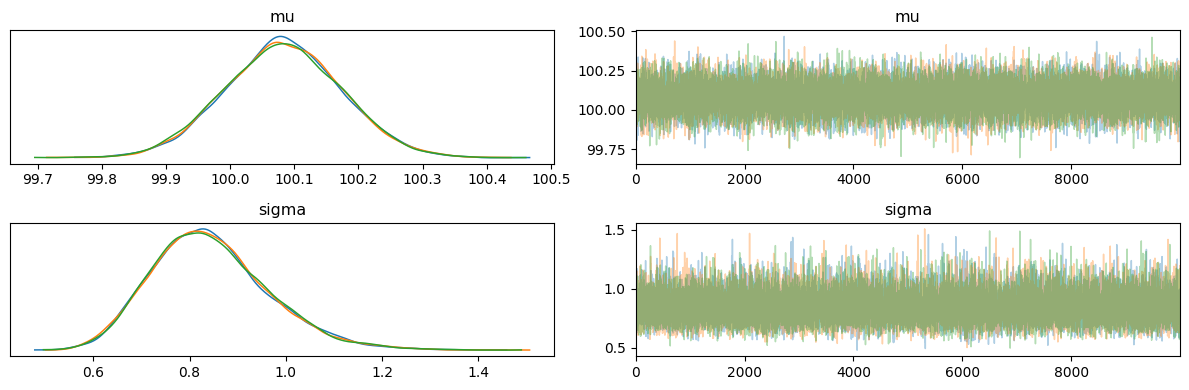

In [20]:
axes = az.plot_trace(idata1, compact=False)
plt.tight_layout()

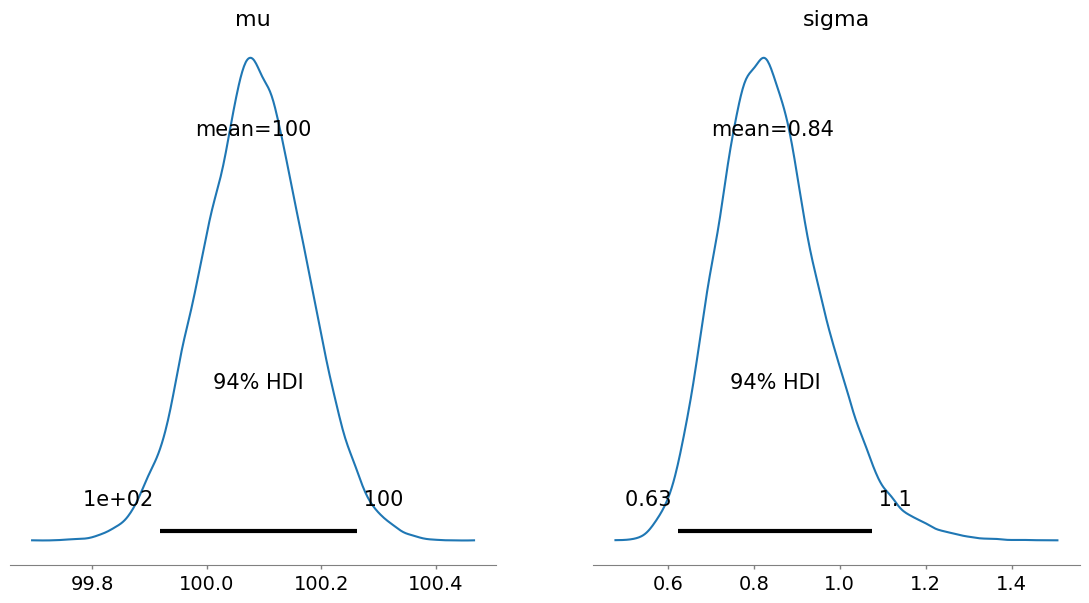

In [21]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(idata1)

In [22]:
summary1 = az.summary(idata1)
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,100.082,0.091,99.919,100.262,0.001,0.000,28269.0,20985.0,1.0
sigma,0.844,0.123,0.625,1.075,0.001,0.001,28565.0,23212.0,1.0


事前分布を一様分布にしてもほとんど同一の結果が得られた

ちなみに、学習サンプルは平均100,標準偏差1の母集団からサンプリングしたが、標本分散が0.8程度であるため、分散の事後分布は0.8程度に収束している

## pystanの基本
pystanではstanコードを文字列として渡すことでMCMCを実行できる。jupyter上でpystanを実行するにはnest_asyncioを利用して非同期処理できるようにする。

In [23]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import stan

import nest_asyncio
nest_asyncio.apply()

In [24]:
rng = np.random.default_rng(123)
Y = rng.normal(100, 1, 100)

nu_0 = 1
kappa_0 = 1
mu_0 = 100
sigma_0 = 1
n = len(Y)
x_bar = Y.mean()
s = Y.var()

stanコードは次のように文字列で記述される。もちろん別のファイルにすることも可能。

stanコードは次のブロックから構成される。
- functionブロック \
    自作関数の定義
- dataブロック \
    利用するデータやサンプルサイズの定義
- transformed dataブロック \
    データの変換の定義
- parametersブロック \
    事後分布を得たいパラメータの定義
- transformed parametersブロック \
    パラメータの変換の定義
- modelブロック \
    モデルの構造を定義
- generated quantitiesブロック \
    パラメータ以外に事後分布を得たい場合はここで定義

In [25]:
stan_model = """
data {
    int N;
    vector[N] Y;
}
parameters {
    real mu; 
    real<lower=0> sigma;
}
model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    mu ~ normal(mu_0, 100);
    for (i in 1:N) {
        Y[i] ~ normal(mu, sigma);
    }
}
"""
stan_model = stan_model.replace("mu_0", str(mu_0)).replace("alpha_0", str(nu_0/2)).replace("beta_0", str(1/(nu_0*sigma_0/2)))

ここでは確率モデルをfor文で定義したが、次のようにベクトルのまま定義することもできる。

In [26]:
stan_model = """
data {
    int N;
    vector[N] Y;
}
parameters {
    real mu; 
    real<lower=0> sigma;
}
model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    mu ~ normal(mu_0, 100);
    
    Y ~ normal(mu, sigma);
    
}
"""
stan_model = stan_model.replace("mu_0", str(mu_0)).replace("alpha_0", str(nu_0/2)).replace("beta_0", str(1/(nu_0*sigma_0/2)))

In [27]:
sample_size = len(Y)

stan_data = {
    'N': sample_size,
    'Y': Y
}

stan.buildにstanコードとデータを与えることでモデルをコンパイルできる。キャッシュにない場合コンパイルには少し時間がかかる。

In [28]:
sm = stan.build(program_code=stan_model, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/27hcukzt/model_27hcukzt.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 15.5s, done.Messages from stanc:
Warning in '/tmp/httpstan_gqxzty8j/model_27hcukzt.stan', line 12, column 21: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_gqxzty8j/model_27hcukzt.stan', line 12, column 16: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


sm.sampleによってMCMCサンプリングを実行する。sample関数の引数はstanの[stan::services::sample::hmc_nuts_diag_e_adapt](https://github.com/stan-dev/stan/blob/develop/src/stan/services/sample/hmc_nuts_diag_e_adapt.hpp)に渡される。

In [29]:
fit = sm.sample(num_chains=3, num_samples=10000, num_warmup=2000, num_thin=1)

Sampling:   0%
Sampling:  33% (12000/36000)
Sampling:  67% (24000/36000)
Sampling: 100% (36000/36000)
Sampling: 100% (36000/36000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!


In [30]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,100.081,0.091,99.909,100.252,0.001,0.0,25064.0,19459.0,1.0
sigma,0.914,0.066,0.795,1.041,0.000,0.0,26431.0,19588.0,1.0


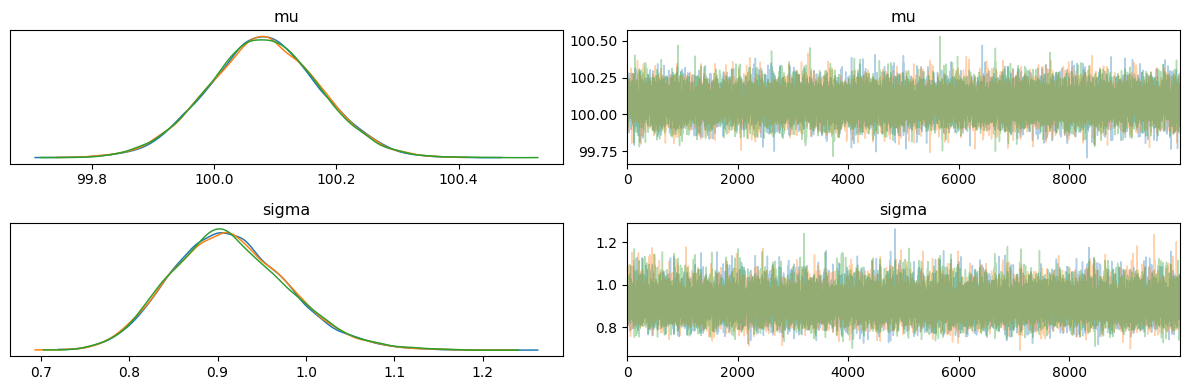

In [31]:
az.plot_trace(fit, compact=False)
plt.tight_layout()

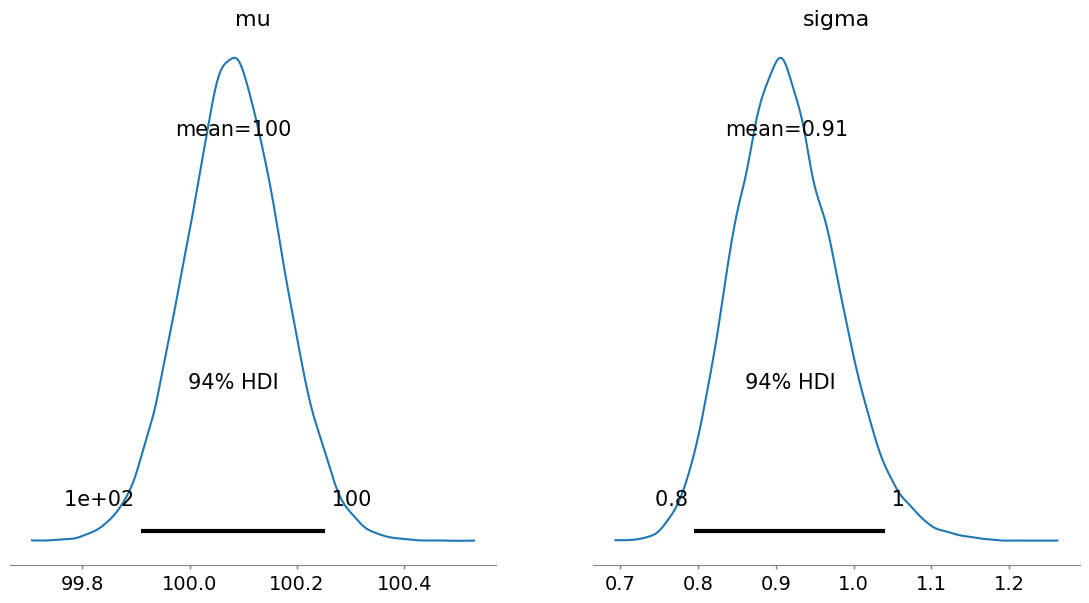

In [32]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(fit)

### 一様事前分布の場合

stanでは事前分布を設定しなければ一様事前分布が設定される。

In [33]:
stan_model = """
data {
    int N;
    vector[N] Y;
}
parameters {
    real mu; 
    real<lower=0> sigma;
}
model {    
    Y ~ normal(mu, sigma);
}
"""

In [34]:
sm = stan.build(program_code=stan_model, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/q3zlc27z/model_q3zlc27z.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 14.4s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [35]:
fit = sm.sample(num_chains=3, num_samples=10000, num_warmup=2000, num_thin=1)

Sampling:   0%
Sampling:  33% (12000/36000)
Sampling:  67% (24000/36000)
Sampling: 100% (36000/36000)
Sampling: 100% (36000/36000), done.
Messages received during sampling:
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!


In [36]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,100.083,0.092,99.907,100.252,0.001,0.0,23659.0,18782.0,1.0
sigma,0.911,0.065,0.792,1.036,0.000,0.0,26688.0,20287.0,1.0


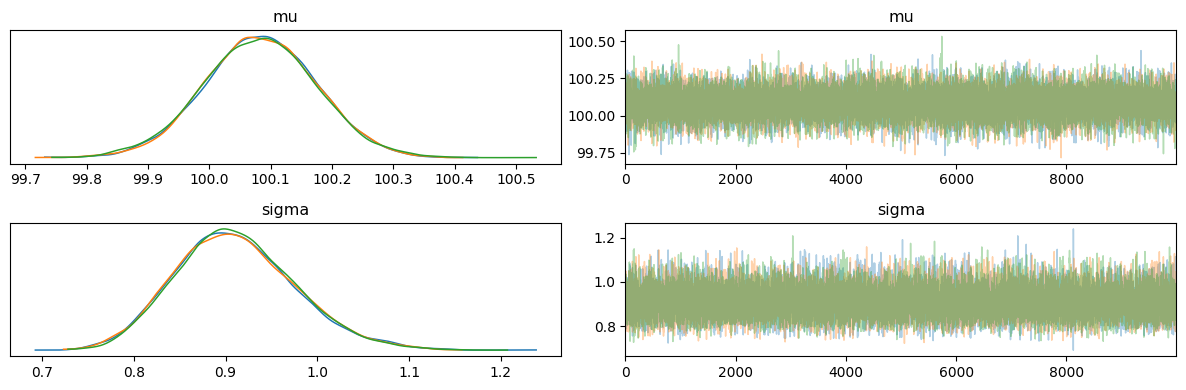

In [37]:
az.plot_trace(fit, compact=False)
plt.tight_layout()